# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [104]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os

In [105]:
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-755391689112
AWS Region: us-east-1
RoleArn: arn:aws:iam::755391689112:role/service-role/AmazonSageMaker-ExecutionRole-20211218T192502


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-21 23:32:25--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  38.2MB/s    in 25s     

2021-12-21 23:32:51 (42.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [59]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

In [ ]:
!aws s3 sync ./dogImages/train s3://${"DEFAULT_S3_BUCKET"}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${"DEFAULT_S3_BUCKET"}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${"DEFAULT_S3_BUCKET"}/dogImages/valid/

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00018.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00018.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg to s3://sagemaker-us-east-1-755391689112/dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg
upload: do

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [60]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 5)    
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [64]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
)
tuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type='Auto'
)

In [65]:
os.environ['SM_CHANNEL_TRAIN'] = 's3://'+bucket+'/dogImages/'
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/dogImages/output/'
s3_location=f"s3://{bucket}/dogImages/"

# Fit HP Tuner
import time
t = time.localtime()
current_time = time.strftime("%H-%M-%S", t)
tuning_job_name = f'dogBreed-Classify-{current_time}'
print(tuning_job_name)

dogBreed-Classify-19-39-25


In [66]:
# TODO: Fit your HP Tuner

tuner.fit({'train': s3_location}, job_name=tuning_job_name, wait=True) # TODO: Remember to include your data channels

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [67]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparams_dict = best_estimator.hyperparameters()


2021-12-29 20:25:54 Starting - Preparing the instances for training
2021-12-29 20:25:54 Downloading - Downloading input data
2021-12-29 20:25:54 Training - Training image download completed. Training in progress.
2021-12-29 20:25:54 Uploading - Uploading generated training model
2021-12-29 20:25:54 Completed - Training job completed


In [106]:
best_hyperparameters = {
    'batch_size': int(best_hyperparams_dict['batch_size'].replace('"', "")),
    'lr': float(best_hyperparams_dict['lr']),
    'epochs': int(best_hyperparams_dict['epochs'])
}
print(f"The best hyperparameters are batch-size {best_hyperparameters['batch_size']}, learning rate {best_hyperparameters['lr']}, and {best_hyperparameters['epochs']} epochs.")

The best hyperparameters are batch-size 128, learning rate 0.0010109087047358175, and 5 epochs.


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [107]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "100", "eval.save_interval": "10"}
)

In [98]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_config,
)

In [99]:
t = time.localtime()
current_time = time.strftime("%H-%M-%S", t)
finetuning_job_name = f'dogBreed-Best-Classify-{current_time}'
print(finetuning_job_name)
print(s3_location)

dogBreed-Best-Classify-22-14-28
s3://sagemaker-us-east-1-755391689112/dogImages/


In [ ]:
estimator.fit({'train': s3_location}, job_name=finetuning_job_name, wait=True)

2021-12-29 22:14:30 Starting - Starting the training job...
2021-12-29 22:14:39 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-29 22:15:53 Starting - Preparing the instances for training......
2021-12-29 22:17:01 Downloading - Downloading input data............
2021-12-29 22:18:55 Training - Downloading the training image..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-29 22:21:10,212 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-29 22:21:10,237 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-29 22:21:10,870 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-29 2

In [109]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2021-12-29 23:47:05.290 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:320 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Training jobname: dogBreed-Best-Classify-22-14-28
[2021-12-29 23:47:05.309 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:320 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/debug-output
[2021-12-29 23:47:06.105 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:320 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-29 23:47:07.125 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:320 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_

In [110]:
tensor_name = "CrossEntropyLoss_output_0"

In [111]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


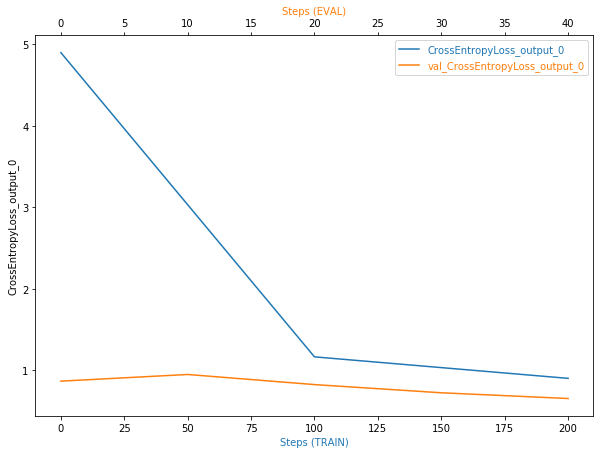

In [112]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

The loss decreases more or less uniformly, which is what we hope for! It looks like there isn't much of an advantage to training past 100 steps, so 5 epochs may be overkill.
If I saw much more jagged lines, I would first try larger batch sizes, in the hopes that more images trained at a time would smooth out the calculated loss.
If I saw loss increasing over time, I would go back to the hyperparameter tuning step, and perhaps start from a different pretrained model.

In [113]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-755391689112/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/profiler-output


Profiler data from system is available


In [114]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"The profiler report is located at {rule_output_path}")

[2021-12-29 23:58:40.827 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:320 INFO metrics_reader_base.py:134] Getting 85 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


The profiler report is located at s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output


In [115]:
! aws s3 ls {rule_output_path} --recursive

2021-12-29 23:41:52     435117 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-29 23:41:51     293984 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-29 23:41:46        569 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-29 23:41:46     415376 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-29 23:41:46       1928 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-29 23:41:46        131 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-29 23:41:46       7260 dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2021-12-29 23:41:46        309 dogBreed

In [116]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/rule-output/Profiler

In [117]:
from IPython.display import FileLink, FileLinks

# Get the profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [118]:
report_file_name = profiler_report_name + "/profiler-output/profiler-report.html"
display("Profiler report link", FileLink(report_file_name))

'Profiler report link'

/root/udacity-deep-learning-project/ProfilerReport/profiler-output/profiler-report.html

## Model Deploying

In [132]:
estimator.model_data

's3://sagemaker-us-east-1-755391689112/dogBreed-Best-Classify-22-14-28/output/model.tar.gz'

In [133]:
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class Image_Predictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(Image_Predictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [134]:
# TODO: Deploy your model to an endpoint
model_location=estimator.model_data
pytorch_model = PyTorchModel(
    model_data=model_location,
    framework_version="1.8",
    py_version="py36", 
    role=role, 
    entry_point='inference.py',
    predictor_cls=Image_Predictor
)


In [135]:
predictor=pytorch_model.deploy(initial_instance_count=1,
                               instance_type="ml.m5.large"
                              )# TODO: Add your deployment configuration like instance type and number of instances

------

KeyboardInterrupt: 

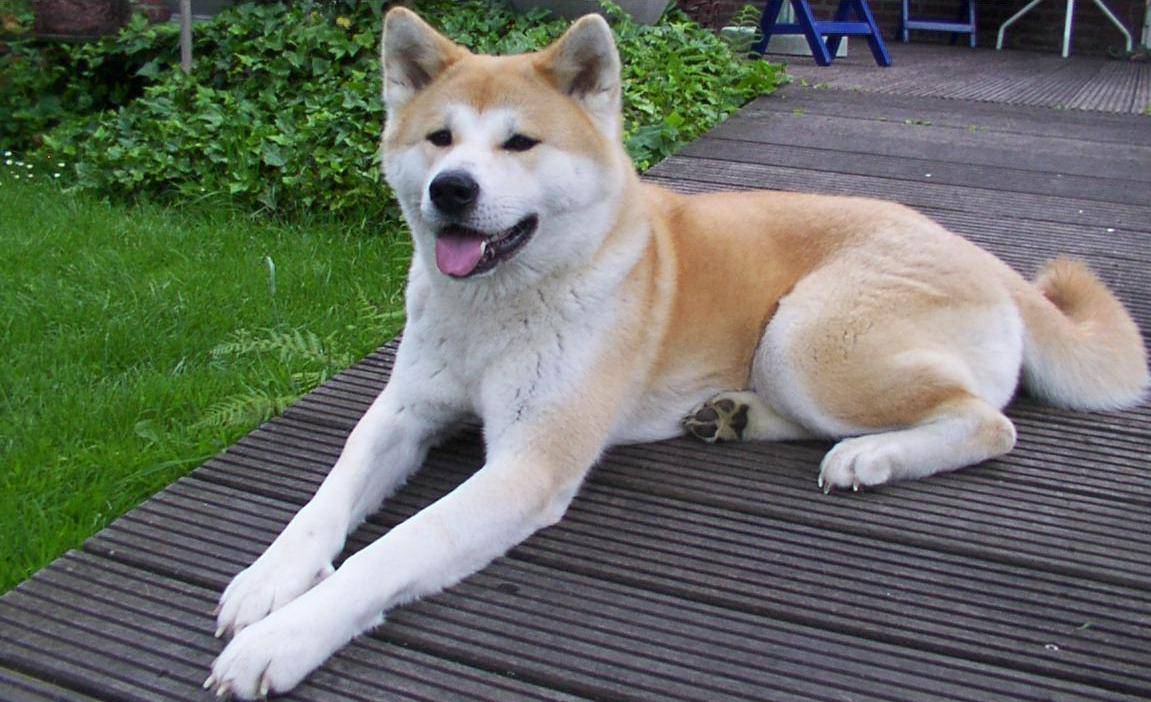

In [127]:
import io
from PIL import Image
import requests
test_image_url = 'https://upload.wikimedia.org/wikipedia/commons/7/78/Akita_inu.jpeg'
payload = requests.get(test_image_url).content
Image.open(io.BytesIO(payload))

In [130]:
response1=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response1

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "Torch not compiled with CUDA enabled
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 126, in transform
    result = self._transform_fn(self._model, input_data, content_type, accept)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 216, in _default_transform_fn
    prediction = self._predict_fn(data, model)
  File "/opt/ml/model/code/inference.py", line 81, in predict_fn
    input_object = input_object.cuda()
  File "/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py", line 164, in _lazy_init
    raise AssertionError("Torch not compiled with CUDA enabled")
AssertionError: Torch not compiled with CUDA enabled
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2021-12-30-00-25-41-335 in account 755391689112 for more information.

In [ ]:
import nu

In [131]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()